In [160]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import lifetimes
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import *
from sklearn.metrics import mean_squared_error
from math import sqrt
from lifetimes import ParetoNBDFitter
from lifetimes.plotting import plot_history_alive
import pickle
from lifetimes import ModifiedBetaGeoFitter


from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
!pip install lightgbm
import lightgbm as lgb
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [161]:
data = pd.read_excel("Online Retail.xlsx")

In [162]:
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [163]:
data.shape

(541909, 8)

In [164]:
data.query('CustomerID==12346')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom


In [165]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [166]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [167]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

<AxesSubplot:>

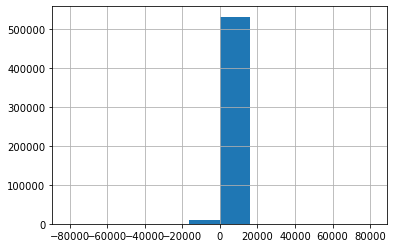

In [168]:
data.Quantity.hist()

We will remove the quantity less than zero, the prices less than zero, and the missing values in the customer ID

In [169]:
# We have to drop the rows where customer ID is null because it's a unique customer ID of each customer
# So it's better to drop rather than imputing it with some random value
data.CustomerID.fillna(0)
data.dropna(axis = 0, subset = ["CustomerID"], inplace = True)
data=data[(data['Quantity']>0)]

In [170]:
data.shape

(397924, 8)

In [171]:
data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

<AxesSubplot:>

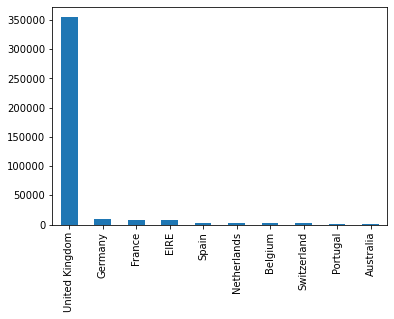

In [172]:
data.Country.value_counts()[:10].plot(kind='bar')

In [173]:
data["Country"].value_counts().head(10)

United Kingdom    354345
Germany             9042
France              8342
EIRE                7238
Spain               2485
Netherlands         2363
Belgium             2031
Switzerland         1842
Portugal            1462
Australia           1185
Name: Country, dtype: int64

In [174]:
px.scatter(data.iloc[:, [5, 7]].groupby(["Country"]).mean(), 
           y = "UnitPrice", size = "UnitPrice", title = "Average Price by Country", opacity = 0.48)

# EDA

<AxesSubplot:xlabel='Description'>

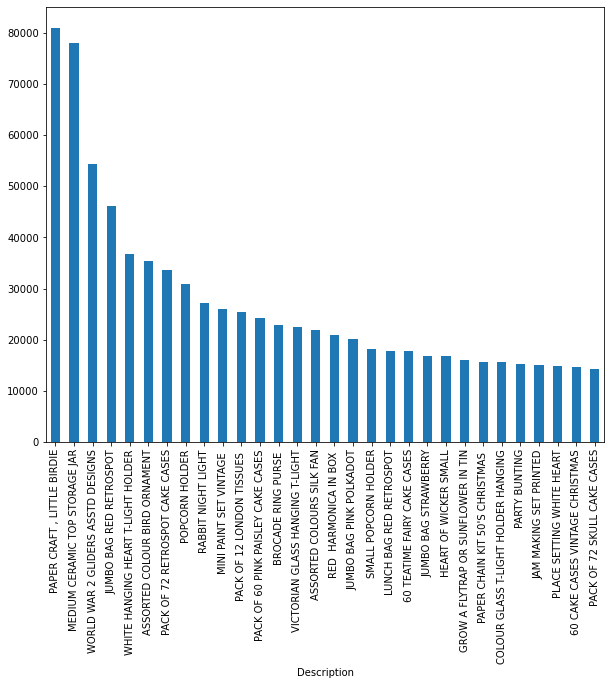

In [175]:
plt.figure(figsize=(10,8))
data.groupby("Description").sum().sort_values(by = "Quantity", ascending = False).head(30)["Quantity"].plot(kind = "bar")

In [176]:
temp_data = data.copy() 

In [177]:
temp_data.loc[:, "Month"] = data.InvoiceDate.dt.month
temp_data.loc[:, "Time"] = data.InvoiceDate.dt.time
temp_data.loc[:, "Year"] = data.InvoiceDate.dt.year
temp_data.loc[:, "Day"] = data.InvoiceDate.dt.day
temp_data.loc[:, "Quarter"] = data.InvoiceDate.dt.quarter
temp_data.loc[:, "Day of Week"] = data.InvoiceDate.dt.dayofweek
#Mapping day of week

In [178]:
dayofweek_mapping = dict({0: "Monday", 
                         1: "Tuesday", 
                         2: "Wednesday" , 
                         3: "Thursday", 
                         4: "Friday", 
                         5: "Saturday", 
                         6: "Sunday"})

In [179]:
temp_data["Day of Week"] = temp_data["Day of Week"].map(dayofweek_mapping)

In [180]:
temp_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,Time,Year,Day,Quarter,Day of Week
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,12,08:26:00,2010,1,4,Wednesday
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,08:26:00,2010,1,4,Wednesday
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,12,08:26:00,2010,1,4,Wednesday
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,08:26:00,2010,1,4,Wednesday
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,08:26:00,2010,1,4,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,12,12:50:00,2011,9,4,Friday
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12,12:50:00,2011,9,4,Friday
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,12,12:50:00,2011,9,4,Friday
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,12,12:50:00,2011,9,4,Friday


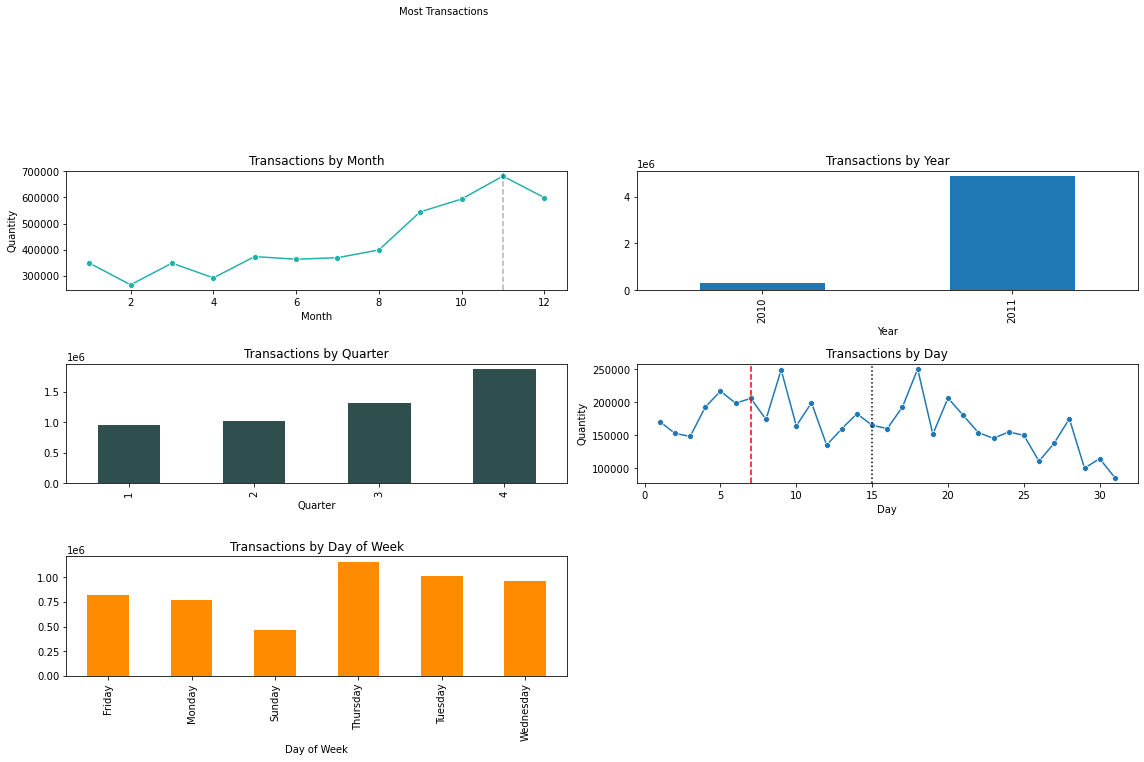

In [181]:
#Plotting the above data
plt.figure(figsize=(16,12))
plt.subplot(3,2,1)
sns.lineplot(x = "Month", y = "Quantity", data = temp_data.groupby("Month").sum("Quantity"), marker = "o", color = "lightseagreen")
plt.axvline(11, color = "k", linestyle = '--', alpha = 0.3)
plt.text(8.50, 1.3e6, "Most Transactions")
plt.title("Transactions by Month")
plt.subplot(3,2,2)
temp_data.groupby("Year").sum()["Quantity"].plot(kind = "bar")
plt.title("Transactions by Year")
plt.subplot(3,2,3)
temp_data.groupby("Quarter").sum()["Quantity"].plot(kind = "bar", color = "darkslategrey")
plt.title("Transactions by Quarter")
plt.subplot(3,2,4)
sns.lineplot(x = "Day", y = "Quantity", data = temp_data.groupby("Day").sum("Quantity"), marker = "o", )
plt.axvline(7, color = 'r', linestyle = '--')
plt.axvline(15, color = 'k', linestyle = "dotted")
plt.title("Transactions by Day")
plt.subplot(3,2,5)
temp_data.groupby("Day of Week").sum()["Quantity"].plot(kind = "bar", color = "darkorange")
plt.title("Transactions by Day of Week")
plt.tight_layout()
plt.show()

In [182]:
data["Total Amount"] = data["Quantity"]*data["UnitPrice"]

In [183]:
summary = lifetimes.utils.summary_data_from_transaction_data(data, "CustomerID", "InvoiceDate", "Total Amount")

In [184]:
summary

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000
...,...,...,...,...
18280.0,0.0,0.0,277.0,0.000000
18281.0,0.0,0.0,180.0,0.000000
18282.0,1.0,119.0,126.0,77.840000


In [185]:
summary = summary.reset_index()

In [186]:
summary.shape

(4339, 5)

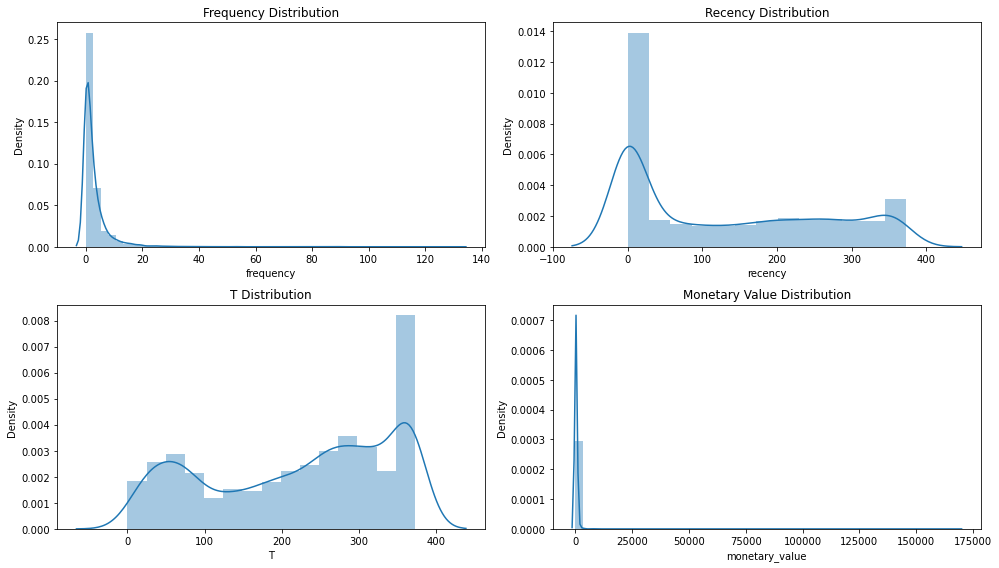

In [187]:
#plotting the distribution
plt.figure(figsize=(14,8))
plt.subplot(221)
sns.distplot(summary["frequency"])
plt.title("Frequency Distribution")
plt.subplot(222)
sns.distplot(summary["recency"])
plt.title("Recency Distribution")
plt.subplot(223)
sns.distplot(summary["T"])
plt.title("T Distribution")
plt.subplot(224)
sns.distplot(summary["monetary_value"])
plt.title("Monetary Value Distribution")
plt.tight_layout()

In [188]:
#checking for the values containing zero.

print("Total Number of Frequency with 0: %s" % (len(summary[summary["frequency"] == 0])))
print("Total Number of Recency with 0: %s" % (len(summary[summary["recency"] == 0])))
print("Total Number of Monetary Value with 0: %s" % (len(summary[summary["monetary_value"] == 0])))

Total Number of Frequency with 0: 1549
Total Number of Recency with 0: 1549
Total Number of Monetary Value with 0: 1549


# Beta Geo - Negative Binomial Distribution + Gamma Gamma Distribution Model

In [189]:
summary_bgf = summary.copy()

In [190]:
summary_bgf.head(2)

,CustomerID,frequency,recency,T,monetary_value
0,12346.0,0.0,0.0,325.0,0.000000
1,12347.0,6.0,365.0,367.0,599.701667


In [191]:
bgf = BetaGeoFitter(penalizer_coef = 0.0)

In [192]:

bgf.fit(summary_bgf["frequency"], summary_bgf["recency"], summary_bgf["T"])

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>

In [193]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.826433,0.026780,0.773944,0.878922
alpha,68.890678,2.611055,63.773011,74.008345
a,0.003443,0.010347,-0.016837,0.023722
b,6.749363,22.412933,-37.179985,50.678711


In [194]:
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>


<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

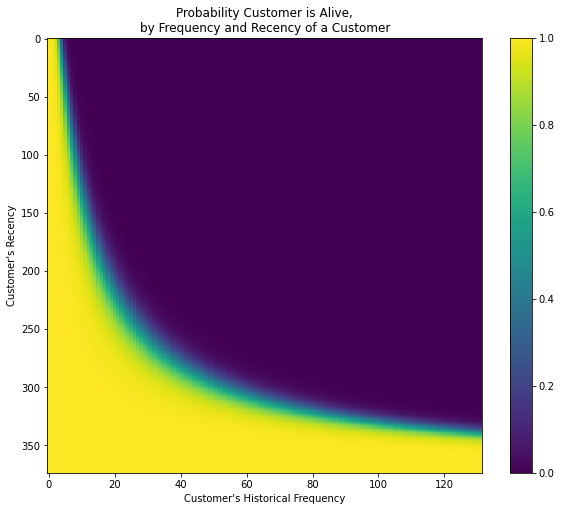

In [195]:
#plotting the churn matrix
plt.figure(figsize=(10,8))
plot_probability_alive_matrix(bgf)

In [196]:
t = 30
summary_bgf["predicted_purchases"] = bgf.conditional_expected_number_of_purchases_up_to_time(t, summary_bgf["frequency"], summary_bgf["recency"], summary_bgf["T"])

In [197]:
summary_bgf.sort_values(by = "predicted_purchases").head(5)

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases
4181,18074.0,0.0,0.0,373.0,0.0,0.056105
2716,16048.0,0.0,0.0,373.0,0.0,0.056105
2884,16274.0,0.0,0.0,373.0,0.0,0.056105
1393,14237.0,0.0,0.0,373.0,0.0,0.056105
1323,14142.0,0.0,0.0,373.0,0.0,0.056105


<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

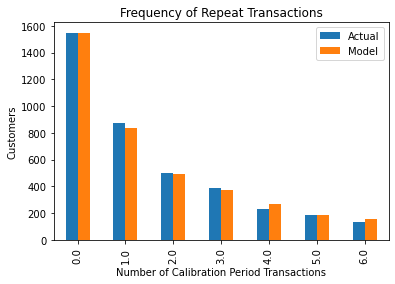

In [198]:
plot_period_transactions(bgf)

In [199]:
#dividing our dataset into training & holdout
summary_cal_holdout = calibration_and_holdout_data(data, "CustomerID", "InvoiceDate", 
                                                   calibration_period_end = '2011-06-08',
                                                  observation_period_end = '2011-12-09')

In [200]:

pd.DataFrame(summary_cal_holdout.head())

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346.0,0.0,0.0,141.0,0.0,184.0
12347.0,2.0,121.0,183.0,4.0,184.0
12348.0,2.0,110.0,174.0,1.0,184.0
12350.0,0.0,0.0,126.0,0.0,184.0
12352.0,3.0,34.0,112.0,3.0,184.0


In [201]:
bgf.fit(summary_cal_holdout["frequency_cal"],
       summary_cal_holdout["recency_cal"],
       summary_cal_holdout["T_cal"])

C:\Users\aleks\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning:

invalid value encountered in sqrt



<lifetimes.BetaGeoFitter: fitted with 2775 subjects, a: 0.00, alpha: 62.56, b: 15091.35, r: 0.74>

In [202]:
summary_cal_holdout

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346.0,0.0,0.0,141.0,0.0,184.0
12347.0,2.0,121.0,183.0,4.0,184.0
12348.0,2.0,110.0,174.0,1.0,184.0
12350.0,0.0,0.0,126.0,0.0,184.0
12352.0,3.0,34.0,112.0,3.0,184.0
...,...,...,...,...,...
18272.0,1.0,21.0,62.0,4.0,184.0
18273.0,0.0,0.0,73.0,2.0,184.0
18280.0,0.0,0.0,93.0,0.0,184.0


<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

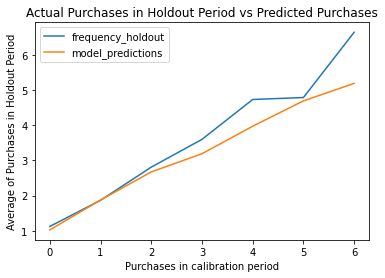

In [203]:
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In [204]:
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346.0,0.0,0.0,141.0,0.0,184.0
12347.0,2.0,121.0,183.0,4.0,184.0
12348.0,2.0,110.0,174.0,1.0,184.0
12350.0,0.0,0.0,126.0,0.0,184.0
12352.0,3.0,34.0,112.0,3.0,184.0


In [205]:
#Creating a function which can predict the future purchased value based on the lookup window

def bgf_get_pred_error(t, id_):
    
    individual = summary_bgf[summary_bgf["CustomerID"] == id_]
    
    ind_pred = bgf.predict(t, individual["frequency"], individual["recency"], individual["T"])
    
    actual_val = individual["frequency"]/individual["recency"]*t
    
    error = actual_val - ind_pred
    
    print("Your Predicted Purchase: %s" % (ind_pred))
    print("Your Actual Purchase: %s" % (actual_val))
    print("Prediction Error: %s" % (error))

In [206]:
bgf_get_pred_error(15, 12348.0)

Your Predicted Purchase: 2    0.133455
dtype: float64
Your Actual Purchase: 2    0.159011
dtype: float64
Prediction Error: 2    0.025556
dtype: float64


<AxesSubplot:title={'center':'History of P_alive'}, ylabel='P_alive'>

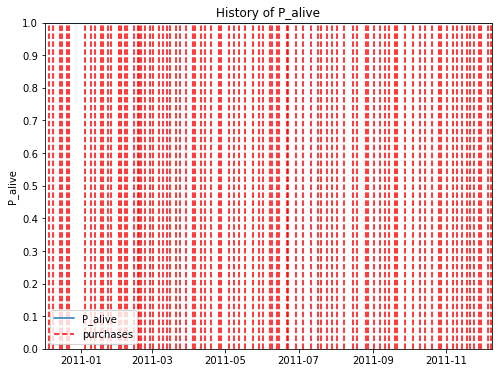

In [207]:
id_1 = 14606.0
id_2 = 12347.0
days_since_birth = 365
sp_trans_1 = data[data["CustomerID"] == id_1]
sp_trans_2 = data[data["CustomerID"] == id_2]
plt.figure(figsize=(8,6))
plot_history_alive(bgf, days_since_birth, sp_trans_1, "InvoiceDate")

<AxesSubplot:title={'center':'History of P_alive'}, ylabel='P_alive'>

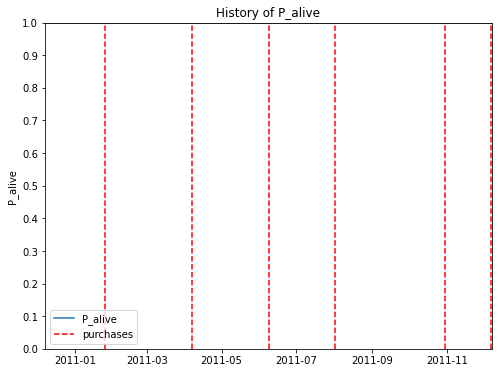

In [208]:
plt.figure(figsize=(8,6))
plot_history_alive(bgf, days_since_birth, sp_trans_2, "InvoiceDate")

In [209]:
summary_bgf["actual_30"] = summary_bgf["frequency"]/summary_bgf["recency"]*30

In [210]:

summary_bgf.head()

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,actual_30
0,12346.0,0.0,0.0,325.0,0.000000,0.062942,NaN
1,12347.0,6.0,365.0,367.0,599.701667,0.469651,0.493151
2,12348.0,3.0,283.0,358.0,301.480000,0.268668,0.318021
3,12349.0,0.0,0.0,18.0,0.000000,0.285291,NaN
4,12350.0,0.0,0.0,310.0,0.000000,0.065433,NaN


In [211]:
summary_bgf = summary_bgf.fillna(value = 0) 
#calculating the prediction error for the 30 days purchase prediction
summary_bgf["Error"] = summary_bgf["actual_30"] - summary_bgf["predicted_purchases"]
mse = mean_squared_error(summary_bgf["actual_30"],summary_bgf["predicted_purchases"])
print("Mean Squared Error: %s" % mse)
print("Average Error:  %s" % summary_bgf["Error"].mean())
print("Root Mean Squared Error: %s" % sqrt(mse))

Mean Squared Error: 2.6924130965406126
Average Error:  0.22026622692481423
Root Mean Squared Error: 1.6408574272436385


In [212]:
bgf_mse_purchase_30 = mean_squared_error(summary_bgf["actual_30"],summary_bgf["predicted_purchases"])
bgf_rmse_purchase_30 = sqrt(bgf_mse_purchase_30)
bgf_avg_error_purchase_30 = summary_bgf["Error"].mean()

In [213]:
summary_bgf.head()

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error
0,12346.0,0.0,0.0,325.0,0.000000,0.062942,0.000000,-0.062942
1,12347.0,6.0,365.0,367.0,599.701667,0.469651,0.493151,0.023500
2,12348.0,3.0,283.0,358.0,301.480000,0.268668,0.318021,0.049354
3,12349.0,0.0,0.0,18.0,0.000000,0.285291,0.000000,-0.285291
4,12350.0,0.0,0.0,310.0,0.000000,0.065433,0.000000,-0.065433


In [214]:
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


In [215]:
data_for_CLV=data[['CustomerID','InvoiceDate','InvoiceNo','Quantity','UnitPrice']]

In [216]:
data_for_CLV['TotalPurchase'] = data_for_CLV['Quantity'] * data_for_CLV['UnitPrice']

In [217]:
data_for_CLV_group=data_for_CLV.groupby('CustomerID').agg({'InvoiceDate': lambda date: (date.max() - date.min()).days,
                                        'InvoiceNo': lambda num: len(num),
                                        'Quantity': lambda quant: quant.sum(),
                                        'TotalPurchase': lambda price: price.sum()})

In [218]:
data_for_CLV_group.head()

,InvoiceDate,InvoiceNo,Quantity,TotalPurchase
CustomerID,,,,
12346.0,0,1,74215,77183.60
12347.0,365,182,2458,4310.00
12348.0,282,31,2341,1797.24
12349.0,0,73,631,1757.55
12350.0,0,17,197,334.40


In [219]:
data_for_CLV_group.columns=['num_days','num_transactions','num_units','spent_money']
data_for_CLV_group.head()

,num_days,num_transactions,num_units,spent_money
CustomerID,,,,
12346.0,0,1,74215,77183.60
12347.0,365,182,2458,4310.00
12348.0,282,31,2341,1797.24
12349.0,0,73,631,1757.55
12350.0,0,17,197,334.40


## CLTV = ((Average Order Value x Purchase Frequency)/Churn Rate) x Profit margin.

## Customer Value = Average Order Value * Purchase Frequency

In [220]:
data_for_CLV_group['avg_order_value']=data_for_CLV_group['spent_money']/data_for_CLV_group['num_transactions']
data_for_CLV_group.head()

,num_days,num_transactions,num_units,spent_money,avg_order_value
CustomerID,,,,,
12346.0,0,1,74215,77183.60,77183.600000
12347.0,365,182,2458,4310.00,23.681319
12348.0,282,31,2341,1797.24,57.975484
12349.0,0,73,631,1757.55,24.076027
12350.0,0,17,197,334.40,19.670588


In [221]:
purchase_frequency=sum(data_for_CLV_group['num_transactions'])/data_for_CLV_group.shape[0]

In [222]:
repeat_rate=data_for_CLV_group[data_for_CLV_group.num_transactions > 1].shape[0]/data_for_CLV_group.shape[0]

In [223]:
churn_rate=1-repeat_rate

In [224]:
purchase_frequency,repeat_rate,churn_rate

(91.70868863793501, 0.9834063148190827, 0.016593685180917306)

### Profit margin is the commonly used profitability ratio. It represents how much percentage of total sales has earned as the gain. Let's assume our business has approx 5% profit on the total sale.

In [225]:
data_for_CLV_group['profit_margin']=data_for_CLV_group['spent_money']*0.05

In [226]:
data_for_CLV_group['CLV']=(data_for_CLV_group['avg_order_value']*purchase_frequency)/churn_rate

In [227]:
data_for_CLV_group['cust_lifetime_value']=data_for_CLV_group['CLV']*data_for_CLV_group['profit_margin']

In [228]:
data_for_CLV_group

,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin,CLV,cust_lifetime_value
CustomerID,,,,,,,,
12346.0,0,1,74215,77183.60,77183.600000,3859.1800,4.265723e+08,1.646219e+12
12347.0,365,182,2458,4310.00,23.681319,215.5000,1.308801e+05,2.820466e+07
12348.0,282,31,2341,1797.24,57.975484,89.8620,3.204144e+05,2.879308e+07
12349.0,0,73,631,1757.55,24.076027,87.8775,1.330615e+05,1.169311e+07
12350.0,0,17,197,334.40,19.670588,16.7200,1.087139e+05,1.817696e+06
...,...,...,...,...,...,...,...,...
18280.0,0,10,45,180.60,18.060000,9.0300,9.981260e+04,9.013078e+05
18281.0,0,7,54,80.82,11.545714,4.0410,6.380996e+04,2.578560e+05
18282.0,118,12,103,178.05,14.837500,8.9025,8.200274e+04,7.300294e+05


In [229]:
data_for_CLV['month_yr'] = data_for_CLV['InvoiceDate'].apply(lambda x: x.strftime('%b-%Y'))
data_for_CLV.head()

,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,TotalPurchase,month_yr
0,17850.0,2010-12-01 08:26:00,536365,6,2.55,15.30,Dec-2010
1,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34,Dec-2010
2,17850.0,2010-12-01 08:26:00,536365,8,2.75,22.00,Dec-2010
3,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34,Dec-2010
4,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34,Dec-2010


In [230]:
sale=data_for_CLV.pivot_table(index=['CustomerID'],columns=['month_yr'],values='TotalPurchase',aggfunc='sum',fill_value=0).reset_index()
sale['CLV']=sale.iloc[:,2:].sum(axis=1)

In [231]:
sale.head()

month_yr,CustomerID,Apr-2011,Aug-2011,Dec-2010,Dec-2011,Feb-2011,Jan-2011,Jul-2011,Jun-2011,Mar-2011,May-2011,Nov-2011,Oct-2011,Sep-2011,CLV
0,12346.0,0.00,0.00,0.00,0.00,0.0,77183.60,0.0,0.00,0.0,0.0,0.00,0.00,0.0,77183.60
1,12347.0,636.25,584.91,711.79,224.82,0.0,475.39,0.0,382.52,0.0,0.0,0.00,1294.32,0.0,3673.75
2,12348.0,367.00,0.00,892.80,0.00,0.0,227.44,0.0,0.00,0.0,0.0,0.00,0.00,310.0,1430.24
3,12349.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,1757.55,0.00,0.0,1757.55
4,12350.0,0.00,0.00,0.00,0.00,334.4,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,334.40
